# 使用torch.nn实现二维卷积实验+超参数对比实验+空洞卷积实验

In [1]:
from torchvision.datasets import ImageFolder
import torch.utils.data as Data
import torchvision.transforms as transforms
import  time#导入模块
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
])
BATCH_SIZE = 128
train_dataset = ImageFolder("vehicle_dataset_new/training_dataset",transform = data_transform)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = ImageFolder("vehicle_dataset_new/test_dataset",transform = data_transform)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0][0].size())
print(train_dataset.class_to_idx)
print(test_dataset[0][0].size())
print(test_dataset.class_to_idx)

962
340
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}
torch.Size([3, 64, 64])
{'bus': 0, 'car': 1, 'truck': 2}


In [2]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(128, num_classes)  # 上一层(avg_pool2d)输出为(16,128,3,2) 
#         self.fc = nn.Linear(128*3*2, num_classes)  # 上一层(avg_pool2d)输出为(16,128,3,2) 
    def forward(self, X):
        # print(X.shape)
        out = self.conv(X)
#         print(out.shape)
        out = F.avg_pool2d(out, kernel_size=30)  # 平均池化层将图片的大小变为1*1
#         print(out.shape)
        out = out.squeeze()  # squeeze去除所有item数量为1的维度
#         out = out.flatten(start_dim=1)  # flatten 将高维向量展平为 2 维向量
        # out = out.view(-1, 128)
        # print(out.shape)
        out = self.fc(out)
        return out

In [3]:
def train_epoch(net, data_loader, device):
    net.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    for batch_idx, (data, target) in enumerate(data_loader):
        # print(data)
        # print(target)
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
#         print("output", output)
#         print("prediction", prediction)
#         print("target", target)
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

In [4]:
num_classes = 3
epochs = 20
lr = 0.001
device = torch.device('cpu')
# device = torch.device('cuda')

net = ConvModule().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")


开始训练------0-------------
epoch:0	 train_loss:0.8417 	train_acc: 0.6580 	test_loss: 1.0296 	 test_acc: 0.4088 	 training_time: 44.51
开始训练------1-------------
epoch:1	 train_loss:0.5769 	train_acc: 0.8004 	test_loss: 0.9051 	 test_acc: 0.5794 	 training_time: 45.46
开始训练------2-------------
epoch:2	 train_loss:0.5139 	train_acc: 0.8087 	test_loss: 0.8613 	 test_acc: 0.6441 	 training_time: 44.56
开始训练------3-------------
epoch:3	 train_loss:0.4567 	train_acc: 0.8430 	test_loss: 0.6761 	 test_acc: 0.7206 	 training_time: 45.03
开始训练------4-------------
epoch:4	 train_loss:0.4162 	train_acc: 0.8462 	test_loss: 0.5578 	 test_acc: 0.7588 	 training_time: 41.87
开始训练------5-------------
epoch:5	 train_loss:0.3865 	train_acc: 0.8701 	test_loss: 0.4637 	 test_acc: 0.8265 	 training_time: 44.43
开始训练------6-------------
epoch:6	 train_loss:0.3520 	train_acc: 0.8888 	test_loss: 0.4008 	 test_acc: 0.8324 	 training_time: 44.87
开始训练------7-------------
epoch:7	 train_loss:0.3342 	train_acc: 0.9033 	test

In [5]:
for epoch in range(epochs):
    print("开始训练------" + str(20 + epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{20 + epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")


开始训练------20-------------
epoch:20	 train_loss:0.2286 	train_acc: 0.9324 	test_loss: 0.2685 	 test_acc: 0.9029 	 training_time: 44.41
开始训练------21-------------
epoch:21	 train_loss:0.2025 	train_acc: 0.9366 	test_loss: 0.2565 	 test_acc: 0.9059 	 training_time: 44.56
开始训练------22-------------
epoch:24	 train_loss:0.2000 	train_acc: 0.9314 	test_loss: 0.2123 	 test_acc: 0.9176 	 training_time: 44.91
开始训练------25-------------
epoch:25	 train_loss:0.1834 	train_acc: 0.9459 	test_loss: 0.2598 	 test_acc: 0.8941 	 training_time: 42.16
开始训练------26-------------
epoch:26	 train_loss:0.1995 	train_acc: 0.9293 	test_loss: 0.2323 	 test_acc: 0.9147 	 training_time: 45.19
开始训练------27-------------
epoch:27	 train_loss:0.1863 	train_acc: 0.9345 	test_loss: 0.2313 	 test_acc: 0.9118 	 training_time: 45.08
开始训练------28-------------
epoch:28	 train_loss:0.1811 	train_acc: 0.9335 	test_loss: 0.2490 	 test_acc: 0.9147 	 training_time: 44.81
开始训练------29-------------
epoch:29	 train_loss:0.1659 	train_a

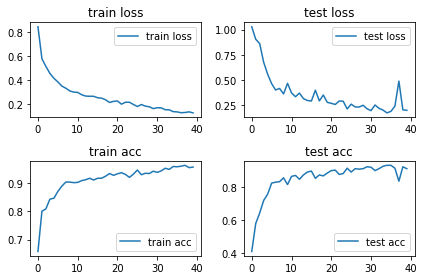

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,label,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label=label)
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list,"train loss","train loss", 221)
plot(test_loss_list,"test loss","test loss", 222)
plot(train_acc_list,"train acc","train acc", 223)
plot(test_acc_list,"test acc","test acc", 224)
plt.tight_layout()
plt.show()


In [22]:
class ConvModule_5(nn.Module):
    """5层卷积"""
    def __init__(self):
        super(ConvModule_5, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Linear(128, num_classes)  # 因为上一层(avg_pool2d)输出为(16,128,3,2) 
#         self.fc = nn.Linear(128*3*2, num_classes)  # 因为上一层(avg_pool2d)输出为(16,128,3,2) 
    def forward(self, X):
        # print(X.shape)
        out = self.conv(X)
#         print(out.shape)
        out = F.avg_pool2d(out, kernel_size=30)  # 平均池化层将图片的大小变为1*1
#         print(out.shape)
        out = out.squeeze()  # squeeze 去除所有item数量为1的维度
#         out = out.flatten(start_dim=1)  # flatten 将高维向量展平为 2 维向量
        # out = out.view(-1, 128)
        # print(out.shape)
        out = self.fc(out)
        return out

In [23]:
net = ConvModule_5().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
train_loss_list_conv5 = []
train_acc_list_conv5 = []
test_loss_list_conv5 = []
test_acc_list_conv5 = []
training_time_list_conv5 = []
epochs = 40
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc  = test_epoch(net, data_loader=test_loader, device=device)
    train_loss_list_conv5.append(train_loss)
    train_acc_list_conv5.append(train_acc)
    test_loss_list_conv5.append(test_loss)
    test_acc_list_conv5.append(test_acc)
    training_time_list_conv5.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")


开始训练------0-------------
epoch:0	 train_loss:0.6726 	train_acc: 0.7152 	test_loss: 1.2944 	 test_acc: 0.2706 	 training_time: 42.22
开始训练------1-------------
epoch:1	 train_loss:0.4547 	train_acc: 0.8306 	test_loss: 1.2916 	 test_acc: 0.4441 	 training_time: 42.70
开始训练------2-------------
epoch:2	 train_loss:0.3938 	train_acc: 0.8638 	test_loss: 0.6624 	 test_acc: 0.7441 	 training_time: 42.35
开始训练------3-------------
epoch:3	 train_loss:0.3347 	train_acc: 0.8773 	test_loss: 0.4959 	 test_acc: 0.7912 	 training_time: 42.33
开始训练------4-------------
epoch:4	 train_loss:0.3010 	train_acc: 0.9012 	test_loss: 0.6459 	 test_acc: 0.7412 	 training_time: 42.13
开始训练------5-------------
epoch:5	 train_loss:0.2821 	train_acc: 0.9096 	test_loss: 0.3836 	 test_acc: 0.8441 	 training_time: 42.30
开始训练------6-------------
epoch:6	 train_loss:0.2829 	train_acc: 0.8971 	test_loss: 0.3865 	 test_acc: 0.8588 	 training_time: 42.47
开始训练------7-------------
epoch:7	 train_loss:0.2626 	train_acc: 0.9158 	test

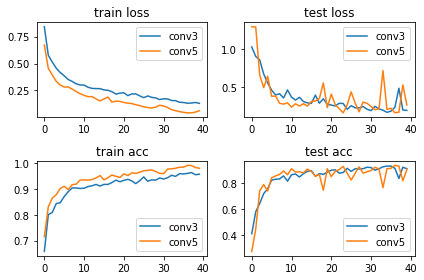

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,train_loss_list_conv5,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label="conv3")
    plt.plot(list(range(len(train_loss_list_conv5))),train_loss_list_conv5, label="conv5")
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list,train_loss_list_conv5,"train loss", 221)
plot(test_loss_list,test_loss_list_conv5,"test loss", 222)
plot(train_acc_list,train_acc_list_conv5,"train acc", 223)
plot(test_acc_list,test_acc_list_conv5,"test acc", 224)
plt.tight_layout()
plt.show()

In [32]:
class ConvModule_dilation(nn.Module):
    def __init__(self):
        super(ConvModule_dilation, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation = 5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.fc = nn.Linear(128, num_classes)  # 上一层(avg_pool2d)输出为(16,128,3,2) 
#         self.fc = nn.Linear(128*3*2, num_classes)  # 上一层(avg_pool2d)输出为(16,128,3,2) 
    def forward(self, X):
        # print(X.shape)
        out = self.conv(X)
#         print(out.shape)
        out = F.avg_pool2d(out, kernel_size=30)  # 平均池化层将图片的大小变为1*1
#         print(out.shape)
        out = out.squeeze()  # squeeze 去除所有item数量为1的维度
#         out = out.flatten(start_dim=1)  # flatten 将高维向量展平为 2 维向量
        # out = out.view(-1, 128)
        # print(out.shape)
        out = self.fc(out)
        return out

In [33]:
num_classes = 3
epochs = 20
lr = 0.001
device = torch.device('cpu')
# device = torch.device('cuda')

net_dilation = ConvModule_dilation().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_dilation.parameters(), lr = lr)

train_loss_list_dilation = []
train_acc_list_dilation = []
test_loss_list_dilation = []
test_acc_list_dilation = []
training_time_list_dilation = []
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net_dilation, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net_dilation, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
epoch:0	 train_loss:0.7619 	train_acc: 0.6746 	test_loss: 0.9864 	 test_acc: 0.6088 	 training_time: 21.90
开始训练------1-------------
epoch:1	 train_loss:0.5163 	train_acc: 0.8150 	test_loss: 0.9952 	 test_acc: 0.4618 	 training_time: 21.86
开始训练------2-------------
epoch:2	 train_loss:0.4546 	train_acc: 0.8389 	test_loss: 0.8264 	 test_acc: 0.6412 	 training_time: 26.74
开始训练------3-------------
epoch:3	 train_loss:0.3820 	train_acc: 0.8597 	test_loss: 0.5753 	 test_acc: 0.7676 	 training_time: 26.54
开始训练------4-------------
epoch:4	 train_loss:0.3509 	train_acc: 0.8742 	test_loss: 0.4749 	 test_acc: 0.8059 	 training_time: 22.01
开始训练------5-------------
epoch:5	 train_loss:0.3282 	train_acc: 0.8784 	test_loss: 0.3770 	 test_acc: 0.8647 	 training_time: 40.16
开始训练------6-------------
epoch:6	 train_loss:0.3308 	train_acc: 0.8909 	test_loss: 0.3602 	 test_acc: 0.8618 	 training_time: 61.45
开始训练------7-------------
epoch:7	 train_loss:0.3031 	train_acc: 0.9002 	test

In [34]:
for epoch in range(epochs):
    print("开始训练------" + str(epoch) + "-------------")

    start = time.time()  #开始时间
    train_loss, train_acc = train_epoch(net_dilation, data_loader=train_loader, device=device)
    end = time.time()  #结束时间
    test_loss, test_acc = 0, 0
    test_loss, test_acc  = test_epoch(net_dilation, data_loader=test_loader, device=device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    training_time_list.append(end - start)
    print(f"epoch:{epoch}\t train_loss:{train_loss:.4f} \t"
          f"train_acc: {train_acc:.4f} \t"
          f"test_loss: {test_loss:.4f} \t test_acc: {test_acc:.4f} \t training_time: {end-start:.2f}")

开始训练------0-------------
epoch:0	 train_loss:0.1588 	train_acc: 0.9501 	test_loss: 0.2141 	 test_acc: 0.9294 	 training_time: 68.27
开始训练------1-------------
epoch:1	 train_loss:0.1624 	train_acc: 0.9418 	test_loss: 0.2411 	 test_acc: 0.8882 	 training_time: 73.51
开始训练------2-------------
epoch:2	 train_loss:0.1966 	train_acc: 0.9272 	test_loss: 0.2733 	 test_acc: 0.9000 	 training_time: 68.43
开始训练------3-------------
epoch:3	 train_loss:0.1672 	train_acc: 0.9366 	test_loss: 0.2773 	 test_acc: 0.9000 	 training_time: 63.71
开始训练------4-------------
epoch:4	 train_loss:0.1594 	train_acc: 0.9376 	test_loss: 0.2038 	 test_acc: 0.9294 	 training_time: 22.18
开始训练------5-------------
epoch:5	 train_loss:0.1524 	train_acc: 0.9501 	test_loss: 0.1999 	 test_acc: 0.9324 	 training_time: 22.17
开始训练------6-------------
epoch:6	 train_loss:0.1342 	train_acc: 0.9563 	test_loss: 0.1886 	 test_acc: 0.9265 	 training_time: 22.04
开始训练------7-------------
epoch:7	 train_loss:0.1289 	train_acc: 0.9511 	test

In [47]:
# print(len(test_acc_list))
# print(test_acc_list[-20:])
# print(test_acc_list[-40:-20])
# print(test_acc_list[-40:])
# print(test_acc_list[:40])
train_loss_list_dilation = train_loss_list[-40:]
train_acc_list_dilation = train_acc_list[-40:]
test_loss_list_dilation = test_loss_list[-40:]
test_acc_list_dilation = test_acc_list[-40:]
training_time_list_dilation = training_time_list[-40:]

92


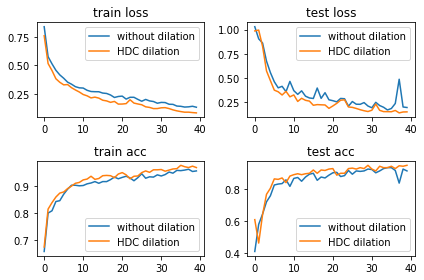

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(train_loss_list,train_loss_list_conv5,title, subplot):
    ax1 = plt.subplot(subplot)
    plt.plot(list(range(len(train_loss_list))),train_loss_list, label="without dilation")
    plt.plot(list(range(len(train_loss_list_conv5))),train_loss_list_conv5, label="HDC dilation")
    ax1.set_title(title)
    ax1.legend()
#     plt.title(title)
#     plt.legend()
#     plt.show()
plot(train_loss_list[:40],train_loss_list_dilation,"train loss", 221)
plot(test_loss_list[:40],test_loss_list_dilation,"test loss", 222)
plot(train_acc_list[:40],train_acc_list_dilation,"train acc", 223)
plot(test_acc_list[:40],test_acc_list_dilation,"test acc", 224)
plt.tight_layout()
plt.show()